In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score
import seaborn as sns
sns.set(font_scale = 1)
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

/Users/aishwaryachandar/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/aishwaryachandar/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


References:


Dataset - https://www.kaggle.com/uciml/adult-census-income/data


XGBoost Parameters - https://github.com/dmlc/xgboost/blob/master/doc/parameter.md


The incredible Jesse Steinweg - https://jessesw.com/ and his blog that guided me through this https://jessesw.com/XG-Boost/

In [2]:
# Read the adult census data set 
raw_data = pd.read_csv('adult.csv')

In [3]:
raw_data.head()
raw_data.info()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education.num     32561 non-null int64
marital.status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital.gain      32561 non-null int64
capital.loss      32561 non-null int64
hours.per.week    32561 non-null int64
native.country    32561 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [4]:
## Data prep

# Let's clean up some of the fields, we can see some columns containing a '?'
# Instead of dropping the rows which contain '?', replace ? with Unknown to see if we can identify some trends with it

clean_data = raw_data.replace('?', 'Unknown')
clean_data.head()

# For each of the categorical fields, let's check the unique categories

print ('\nWorkClass ', clean_data.workclass.unique())
print ('\nEducation ', clean_data.education.unique())
print ('\nMarital Status ', clean_data['marital.status'].unique())
print ('\nOccupation ', clean_data.occupation.unique())
print ('\nRelationship ', clean_data.relationship.unique())
print ('\nRace ', clean_data.race.unique())
print ('\nSex ', clean_data.sex.unique())
print ('\nNative Country ', clean_data['native.country'].unique())
print ('\nIncome Class ', clean_data.income.unique())


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,Unknown,77053,HS-grad,9,Widowed,Unknown,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,Unknown,186061,Some-college,10,Widowed,Unknown,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K



WorkClass  ['Unknown' 'Private' 'State-gov' 'Federal-gov' 'Self-emp-not-inc'
 'Self-emp-inc' 'Local-gov' 'Without-pay' 'Never-worked']

Education  ['HS-grad' 'Some-college' '7th-8th' '10th' 'Doctorate' 'Prof-school'
 'Bachelors' 'Masters' '11th' 'Assoc-acdm' 'Assoc-voc' '1st-4th' '5th-6th'
 '12th' '9th' 'Preschool']

Marital Status  ['Widowed' 'Divorced' 'Separated' 'Never-married' 'Married-civ-spouse'
 'Married-spouse-absent' 'Married-AF-spouse']

Occupation  ['Unknown' 'Exec-managerial' 'Machine-op-inspct' 'Prof-specialty'
 'Other-service' 'Adm-clerical' 'Craft-repair' 'Transport-moving'
 'Handlers-cleaners' 'Sales' 'Farming-fishing' 'Tech-support'
 'Protective-serv' 'Armed-Forces' 'Priv-house-serv']

Relationship  ['Not-in-family' 'Unmarried' 'Own-child' 'Other-relative' 'Husband' 'Wife']

Race  ['White' 'Black' 'Asian-Pac-Islander' 'Other' 'Amer-Indian-Eskimo']

Sex  ['Female' 'Male']

Native Country  ['United-States' 'Unknown' 'Mexico' 'Greece' 'Vietnam' 'China' 'Taiwan'
 'India'

In [5]:
## All the categories now seem to be clean. 

# Applying ordinal encoding for categorical features to be compliant with XGBoost

# Identify which fields are categorical and then replace them with the codes
for column in clean_data.columns:
    if clean_data[column].dtype == 'object':
        clean_data[column]= pd.Categorical(clean_data[column]).codes

In [6]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null int8
fnlwgt            32561 non-null int64
education         32561 non-null int8
education.num     32561 non-null int64
marital.status    32561 non-null int8
occupation        32561 non-null int8
relationship      32561 non-null int8
race              32561 non-null int8
sex               32561 non-null int8
capital.gain      32561 non-null int64
capital.loss      32561 non-null int64
hours.per.week    32561 non-null int64
native.country    32561 non-null int8
income            32561 non-null int8
dtypes: int64(6), int8(9)
memory usage: 1.8 MB


In [7]:
# Let's split the data randomly into a 70:30 split

x_train = clean_data.sample(frac = 0.7)
x_test = clean_data[~clean_data.index.isin(x_train.index)]
x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)

print ('Train Data Length ', len(x_train))
print ('Test Data Length ', len(x_test))

Train Data Length  22793
Test Data Length  9768


In [8]:
# Set up the labels
y_train = x_train.pop('income')
y_test = x_test.pop('income')

In [9]:
cv_params = {'max_depth': [3,5], 'min_child_weight': [1,3]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'seed': 0, 'subsample': 0.5, 'colsample_bytree': 0.5,
             'objective': 'binary:logistic'}

optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, scoring = 'accuracy', cv = 5, n_jobs = -1)

In [10]:
optimized_GBM.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.5),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [3, 5], 'min_child_weight': [1, 3]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [11]:
optimized_GBM.grid_scores_

[mean: 0.86838, std: 0.00271, params: {'max_depth': 3, 'min_child_weight': 1},
 mean: 0.86913, std: 0.00353, params: {'max_depth': 3, 'min_child_weight': 3},
 mean: 0.86246, std: 0.00301, params: {'max_depth': 5, 'min_child_weight': 1},
 mean: 0.86215, std: 0.00453, params: {'max_depth': 5, 'min_child_weight': 3}]

In [12]:
# Trying with different set of parameters 

cv_params = {'max_depth': [3,5], 'min_child_weight': [1,3]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'seed': 0, 'subsample': 0.6, 'colsample_bytree': 0.7,
             'objective': 'binary:logistic'}

optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, scoring = 'accuracy', cv = 5, n_jobs = -1)

In [13]:
optimized_GBM.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.6),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [3, 5], 'min_child_weight': [1, 3]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [14]:
optimized_GBM.grid_scores_

[mean: 0.86851, std: 0.00227, params: {'max_depth': 3, 'min_child_weight': 1},
 mean: 0.86763, std: 0.00349, params: {'max_depth': 3, 'min_child_weight': 3},
 mean: 0.86127, std: 0.00485, params: {'max_depth': 5, 'min_child_weight': 1},
 mean: 0.86105, std: 0.00475, params: {'max_depth': 5, 'min_child_weight': 3}]

In [15]:
# Settling on the below parameters and trying out early stopping CV from the XGBoost module using 10 folds
# Max_Dept = 3
# Min_Child_Weight = 3
# colsample_bytree = 0.7
# subsample = 0.6
# Learning rate = 0.1


# Creating a DMatrix to increase performance - sorts the data initially to optimize for XGBoost when building trees.

xgdmat = xgb.DMatrix(x_train, y_train)

final_params = {'learning_rate': 0.1, 'seed': 0, 'subsample': 0.6, 'colsample_bytree': 0.7,
             'objective': 'binary:logistic', 'max_depth': 3, 'min_child_weight': 3}

# Set early stopping rounds to 50 to indicate that accuracy shouldn't imporve for at least 50 new trees
cv_xgb = xgb.cv(params = final_params, dtrain = xgdmat, num_boost_round = 3000, nfold = 10, metrics = ['error'],
                            early_stopping_rounds = 50)

In [16]:
cv_xgb.tail(10)

,test-error-mean,test-error-std,train-error-mean,train-error-std
343,0.127582,0.006288,0.117005,0.000889
344,0.127758,0.006324,0.116961,0.000819
345,0.127626,0.006389,0.116941,0.000856
346,0.127626,0.006066,0.116951,0.000830
347,0.127582,0.006051,0.116932,0.000816
348,0.127714,0.005909,0.116815,0.000729
349,0.127670,0.006137,0.116741,0.000745
350,0.127538,0.006361,0.116771,0.000791
351,0.127582,0.006148,0.116751,0.000781
352,0.127451,0.006007,0.116815,0.000785


In [17]:
# Create the final xgboost model

final_xgb = xgb.train(final_params, xgdmat, num_boost_round=288)

'\nAs expected, the fnlwgt which is a term derived from socio-economic characteristics of the population. \nSimilarly, age and capital gains also shows up as important while race, sec and native country are lower on the scale of importance.\nThis ordering of feature importance is specific to this classification task and could be very different if we do a predictive regression task.\n'

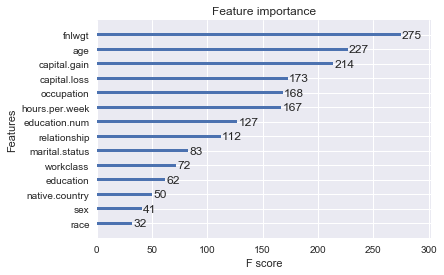

In [18]:
# Plot feature importance from the final xgb model
xgb.plot_importance(final_xgb)

'''
As expected, the fnlwgt which is a term derived from socio-economic characteristics of the population. 
Similarly, age and capital gains also shows up as important while race, sec and native country are lower on the scale of importance.
This ordering of feature importance is specific to this classification task and could be very different if we do a predictive regression task.
'''

In [19]:
# Let's see how well our model predicts on the test data

testdmat = xgb.DMatrix(x_test)
# Get the predicted probilites for the test set
y_pred = final_xgb.predict(testdmat)
# Convert the probabilites to classes
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0
y_pred

array([ 1.,  1.,  1., ...,  0.,  0.,  0.], dtype=float32)

In [20]:
# Calculating the accuracy using sklearn.metrics
print ("Accuracy of the XGBoost Model" , float('%.3f'%(accuracy_score(y_pred, y_test)*100)), "%")

Accuracy of the XGBoost Model 86.937 %
